<a href="https://colab.research.google.com/github/MadelayneLoor/ABSA_Tesis/blob/main/AbsaMade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ABSA basado en textos de retroalimentacione educativas

## Importacion de los paquetes necesarios

In [1]:
#pip install numpy
#pip install pandas
#pip install matplotlib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [4]:
# Importacion de los paquetes necesarios
data = pd.read_csv('/content/datasetABSA.csv')
# Head del dataframe
data.head()

,Comentario,Aspecto,Polaridad
0,la caratula sin errores ortograficos,caratula,2
1,la estructura del documento se visualiza corre...,estructura,1
2,no existen herencias la relacion entre los cas...,herencias,0
3,al existir tantos errores en el procedimientos...,errores,0
4,la caratula sin errores ortograficos,caratula,2


In [5]:
data.shape

(4253, 3)

In [6]:
summary = data.describe(include='all')
summary

,Comentario,Aspecto,Polaridad
count,4253,4253,4253.000000
unique,3564,218,NaN
top,el flujo base y flujo alterno de las actividad...,nombre,NaN
freq,23,283,NaN
mean,NaN,NaN,0.962850
std,NaN,NaN,0.853598
min,NaN,NaN,0.000000
25%,NaN,NaN,0.000000
50%,NaN,NaN,1.000000
75%,NaN,NaN,2.000000


In [7]:
longest_sentence_length = data['Comentario'].apply(len).max()
longest_sentence_length

765

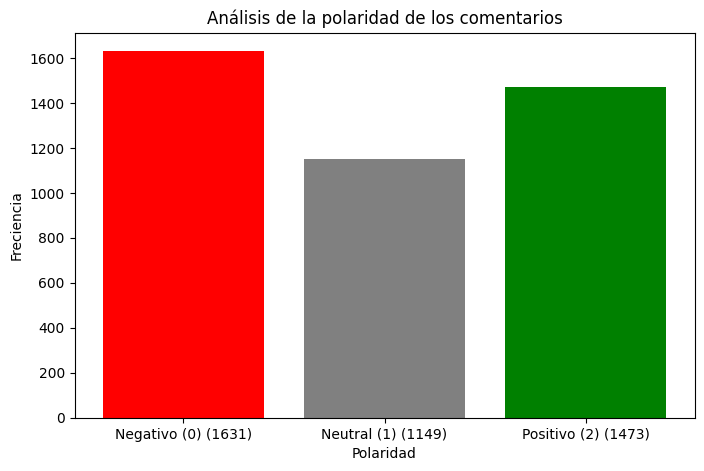

In [8]:
labels = ['Negativo (0)', 'Neutral (1)', 'Positivo (2)']
polarity_counts = data['Polaridad'].value_counts().sort_index()
polarity_counts_sorted = polarity_counts.sort_index()
adjusted_labels = [f'{label} ({count})' for label, count in zip(labels[:len(polarity_counts_sorted)], polarity_counts_sorted)]

plt.figure(figsize=(8, 5))
plt.bar(adjusted_labels, polarity_counts_sorted, color=['red', 'gray', 'green'] [:len(polarity_counts_sorted)])

plt.title('Análisis de la polaridad de los comentarios')
plt.xlabel('Polaridad')
plt.ylabel('Freciencia')
plt.show()


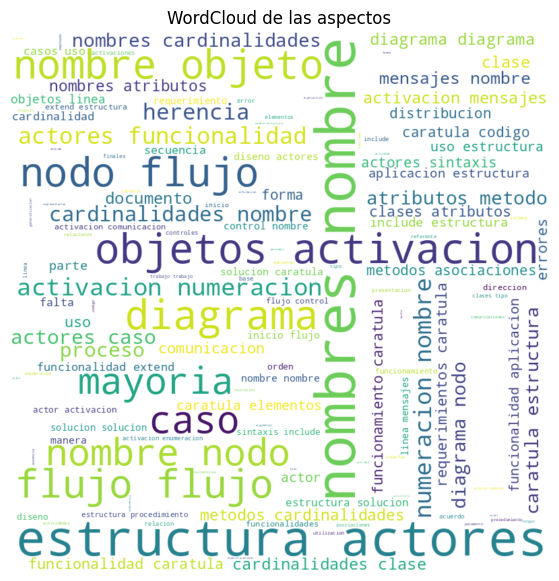

In [9]:
aspectt_text = " ".join(data['Aspecto'])
wordcloud = WordCloud(width=800, height=800, background_color="white").generate(aspectt_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud de las aspectos")
plt.show()


## Porcesamiento de data

In [10]:
data['Comentario'] = data.apply(lambda row: f"[CLS] {row['Comentario']} [SEP] {row['Aspecto']} [SEP]", axis=1)

In [11]:
data.head()

,Comentario,Aspecto,Polaridad
0,[CLS] la caratula sin errores ortograficos [SE...,caratula,2
1,[CLS] la estructura del documento se visualiza...,estructura,1
2,[CLS] no existen herencias la relacion entre l...,herencias,0
3,[CLS] al existir tantos errores en el procedim...,errores,0
4,[CLS] la caratula sin errores ortograficos [SE...,caratula,2


In [12]:
from sklearn.model_selection import train_test_split

train_data, temp_data = train_test_split(
    data,
    test_size=0.3,
    random_state=42,
    stratify=data['Polaridad']
)

val_data, test_data = train_test_split(
    temp_data,
    test_size=0.5,
    random_state=42,
    stratify=temp_data['Polaridad']
)

print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Train samples: {len(train_data)}")


Validation samples: 638
Test samples: 638
Train samples: 2977


## Entrenamiendo del modelo

In [13]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [14]:
from torch.utils.data import Dataset, DataLoader
import torch

class SentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        sentence = row["Comentario"]
        label = row["Polaridad"]

        encoding = self.tokenizer(
            sentence,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }

In [15]:
# Tokkenizador ve dataset

from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
max_len = 128

train_dataset = SentimentDataset(train_data, tokenizer, max_len)
val_dataset = SentimentDataset(val_data, tokenizer, max_len)
test_dataset = SentimentDataset(test_data, tokenizer, max_len)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8)
test_dataloader = DataLoader(test_dataset, batch_size=8)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [17]:
from transformers import BertForSequenceClassification, get_scheduler

#Modelo

model = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased',  num_labels=3)

model.to(device)

#optimizar an scheduler

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.005)
num_training_steps = len(train_dataloader) * 3  # 3 epoch
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps,
)


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
from tqdm import tqdm

def train_one_epoch(model, data_loader, optimizer, device, scheduler=None):
    model.train()
    total_loss = 0

    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()

    avg_loss = total_loss / len(data_loader)
    return avg_loss

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [20]:
def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)

 # calcular métricas
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')


    return avg_loss, accuracy, precision, recall, f1

## Entrenamiendo del modelocon 5 epocas

In [21]:
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss = train_one_epoch(model, train_dataloader, optimizer, device, lr_scheduler)
    val_loss, accuracy, precision, recall, f1 = evaluate(model, val_dataloader, device)
    print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Epoch 1/5


Evaluation: 100%|██████████| 80/80 [00:04<00:00, 17.31it/s]


Training Loss: 0.4595, Validation Loss: 0.1292
Accuracy: 0.9498, Precision: 0.9511, Recall: 0.9498, F1-score: 0.9502
Epoch 2/5


Evaluation: 100%|██████████| 80/80 [00:04<00:00, 16.50it/s]


Training Loss: 0.1477, Validation Loss: 0.1080
Accuracy: 0.9624, Precision: 0.9634, Recall: 0.9624, F1-score: 0.9626
Epoch 3/5


Evaluation: 100%|██████████| 80/80 [00:04<00:00, 16.44it/s]


Training Loss: 0.0554, Validation Loss: 0.1175
Accuracy: 0.9561, Precision: 0.9584, Recall: 0.9561, F1-score: 0.9566
Epoch 4/5


Evaluation: 100%|██████████| 80/80 [00:04<00:00, 16.10it/s]


Training Loss: 0.0391, Validation Loss: 0.1175
Accuracy: 0.9561, Precision: 0.9584, Recall: 0.9561, F1-score: 0.9566
Epoch 5/5


Evaluation: 100%|██████████| 80/80 [00:04<00:00, 16.54it/s]

Training Loss: 0.0363, Validation Loss: 0.1175
Accuracy: 0.9561, Precision: 0.9584, Recall: 0.9561, F1-score: 0.9566


## Guardar el modelo

In [22]:
save_directory = "ABSA_model_v1"

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Modelo Tokenizado '{save_directory}' guardado!!!")

Modelo Tokenizado 'ABSA_model_v1' guardado!!!


## Porceso de prueba

In [23]:

def test_model(model, data_loader, device):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():

        for batch in data_loader:

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average="weighted")
    return accuracy, f1

test_accuracy, test_f1 = test_model(model, test_dataloader, device)
print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")


Test Accuracy: 0.9592, Test F1 Score: 0.9595


## Pueba del modelo

In [24]:
def predict_aspect_sentiment(model, tokenizer, text, aspect, device, max_len=128):


    formatted_text = f"[CLS] {text} [SEP] {aspect} [SEP]"

    encoding = tokenizer(
        formatted_text,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )

    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    label_mapping_reverse = {0: "Negativo", 1: "Neutral", 2: "Positivo"}
    sentiment = label_mapping_reverse[predicted_class]

    return sentiment


In [25]:
text = "Los actores estan mal establecidos"
aspect = "actores"

predicted_sentiment = predict_aspect_sentiment(
    model, tokenizer, text, aspect, device
)

print(f"Aspect: {predicted_sentiment}")

Aspect: Negativo


## 30 ejemplos de retroalimentación fundamentos de software

In [ ]:
comments = [
    "los actores en el diagrama de secuencia interactuan de manera eficiente para completar el flujo",
"los actores en el caso de uso deben tener roles claramente definidos para evitar confusiones",
"el diagrama de actividad muestra como los actores transitan por las diferentes etapas del proceso",
"es fundamental que los actores en el sistema se comuniquen correctamente a través de los mensajes",
"el caso de uso describe de manera clara las interacciones entre los actores y el sistema",
"los actores deben ser capaces de realizar todas las acciones indicadas en el diagrama de actividad",
"en el diagrama de secuencia, los actores realizan las acciones en el orden correcto para mantener la coherencia",
"los actores deben estar claramente definidos en el caso de uso para evitar ambigüedades",
"en el diagrama de actividad, los actores tienen una representación visual que facilita la comprensión del flujo",
"la comunicación entre actores y el sistema es esencial para que el caso de uso funcione correctamente",
"los actores son responsables de iniciar el flujo en el diagrama de secuencia",
"el diagrama de actividad tiene que representar de manera precisa los pasos que siguen los actores",
"los actores deben tener roles bien definidos para que el diagrama de actividad no se vuelva confuso",
"es importante que los actores sean consistentes en sus interacciones dentro del caso de uso",
"el diagrama de secuencia ayuda a entender cómo interactúan los actores con el sistema en cada paso",
"los actores deben tener acceso a todas las herramientas necesarias para ejecutar el flujo en el diagrama de actividad",
"el caso de uso describe claramente las acciones de los actores, desde el inicio hasta el final del proceso",
"en el diagrama de secuencia, los actores deben estar alineados con el comportamiento esperado del sistema",
"el diagrama de actividad facilita la visualización de cómo los actores interactúan con el sistema",
"los actores deben tener acceso a las interfaces que les permiten realizar las acciones necesarias en el diagrama de actividad",
"el flujo de trabajo en el diagrama de secuencia depende de la correcta participación de los actores",
"es necesario que los actores sigan el flujo indicado en el diagrama de actividad para evitar errores",
"los actores deben estar debidamente asignados a las tareas en cada uno de los pasos del caso de uso",
"en el caso de uso, la participación de los actores debe ser clara y sin contradicciones",
"el diagrama de secuencia debe mostrar cómo los actores interactúan con cada componente del sistema",
"en el diagrama de actividad, los actores son responsables de ejecutar cada acción en el proceso",
"los actores deben ser capaces de modificar su comportamiento en el diagrama de actividad si las condiciones cambian",
"el caso de uso debe prever las interacciones necesarias entre los actores y el sistema para funcionar adecuadamente",
"los actores deben estar alineados con los objetivos del sistema descritos en el caso de uso"
]

In [ ]:
aspect = 'actores'

positive_count = 0
negative_count = 0
neutral_count = 0

for comment in comments:
    comment_lower = comment.lower()

    if aspect not in comment_lower:
        continue

    predicted_sentiment = predict_aspect_sentiment(model, tokenizer, comment, aspect, device)

    if predicted_sentiment == "Positivo":
        positive_count += 1
    elif predicted_sentiment == "Negativo":
        negative_count += 1
    elif predicted_sentiment == "Neutral":
        neutral_count += 1

total = positive_count + negative_count
positive_ratio = positive_count / total if total > 0 else 0
negative_ratio = negative_count / total if total > 0 else 0
neutral_ratio = neutral_count / total if total > 0 else 0

score_out_of_5 = positive_ratio * 5

print(f"Aspect: {aspect}")
print(f"Positive Ratio: {positive_ratio:.2f}")
print(f"Negative Ratio: {negative_ratio:.2f}")
print(f"Neutral Ratio: {neutral_ratio:.2f}")
print(f"Score Based on Aspect (out of 5): {score_out_of_5:.1f}")

Aspect: actores
Positive Ratio: 1.00
Negative Ratio: 0.00
Neutral Ratio: 0.00
Score Based on Aspect (out of 5): 5.0
